# MARATÓN BEHIND THE CODE 2020

# DESAFÍO 8 - Digital House

El reto de Digital House tiene que ver con la misión y visión de la empresa; la cual busca transformar la vida de las personas, desarrollando competencias digitales, para que generen un impacto positivo en la sociedad. En ese sentido, Digital House busca a través de este desafío medir la empleabilidad de los cursos que disponibiliza en su plataforma, es decir que tan factible es que un alumno o egresado de Digital House acceda al mercado laboral o consiga un trabajo en su área luego de finalizar uno o varios de los cursos ofrecidos en la plataforma.

Entender que características o variables hacen que una persona sea más o menos empleable es fundamental para la empresa y para generar ese impacto positivo que busca aportar a la sociedad

<hr>

## Instalación de algunas bibliotecas de Python

In [1]:
!pip install scikit-learn --upgrade
!pip install scipy --upgrade

/bin/bash: pip: command not found
/bin/bash: pip: command not found


In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Normalizer

<hr>

## Descargue el conjunto de datos del desafío en formato .csv

In [2]:
import pandas as pd

!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
df_training_dataset = pd.read_csv(r'train_dataset_digitalhouse.csv')
df_training_dataset.tail()

--2020-09-18 18:56:39--  https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.204.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.204.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 654532 (639K) [text/plain]
Saving to: ‘train_dataset_digitalhouse.csv.6’

train_dataset_digit 100%[===================>] 639.19K   423KB/s    in 1.5s    

2020-09-18 18:56:42 (423 KB/s) - ‘train_dataset_digitalhouse.csv.6’ saved [654532/654532]



,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
8990,9995,29.0,MASCULINO,ARGENTINA,TERTIARY,DEVELOPMENT,NaN,4.0,4701.6,9.1,86.0
8991,9996,34.0,NaN,ARGENTINA,UNIVERSITARY,ENGINEERING,PROGRAMACION,3.4,4646.2,16.8,95.0
8992,9997,28.0,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,NaN,3315.1,5.6,95.0
8993,9998,23.0,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,3.3,4437.8,0.9,87.0
8994,9999,36.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,3.4,4600.8,19.6,88.0


## En el conjunto de datos proporcionado, tenemos las siguientes columnas:

* Unnamed: 0
* EDAD
* GENERO
* RESIDENCIA
* NV_ESTUDIO
* ESTUDIO_PREV
* TRACK_DH
* AVG_DH
* MINUTES_DH
* EXPERIENCIA
* **DIAS_EMP = El valor "target" que se va a predecir**

Podemos verificar fácilmente que faltan valores usando el siguiente código:

```df_training_dataset.info()```

Debe manejar cuidadosamente estos valores faltantes antes de crear un modelo de regresión.

In [3]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8995 entries, 0 to 8994
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    8995 non-null   int64  
 1   EDAD          7668 non-null   float64
 2   GENERO        7620 non-null   object 
 3   RESIDENCIA    7638 non-null   object 
 4   NV_ESTUDIO    7623 non-null   object 
 5   ESTUDIO_PREV  7665 non-null   object 
 6   TRACK_DH      7714 non-null   object 
 7   AVG_DH        7651 non-null   float64
 8   MINUTES_DH    7619 non-null   float64
 9   EXPERIENCIA   7618 non-null   float64
 10  DIAS_EMP      8995 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 773.1+ KB


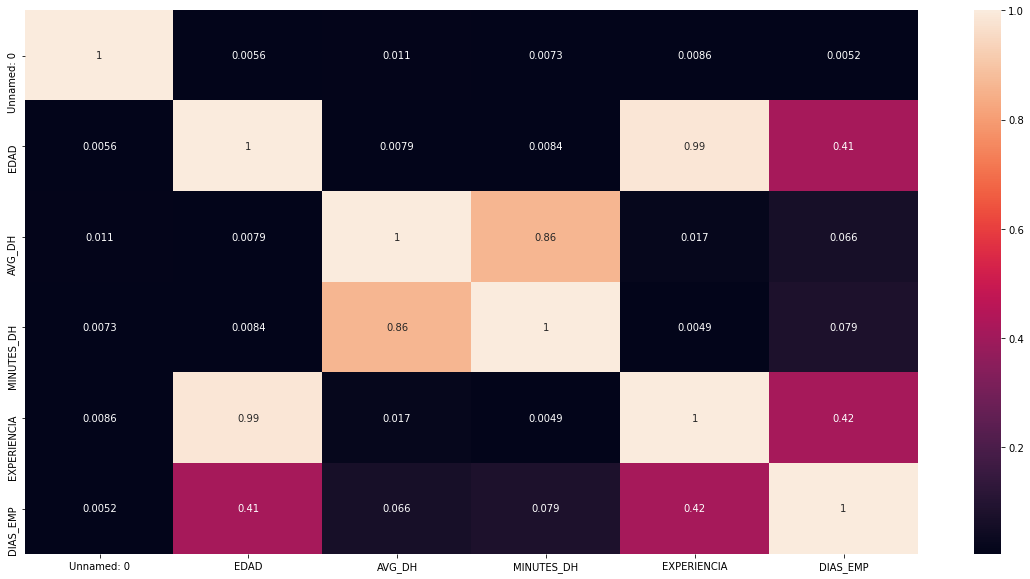

In [19]:
def graficar_correlaciones(df_temp):
    var_num = df_temp._get_numeric_data().columns.values.tolist()
    plt.figure(figsize = (20, 10))
    sns.heatmap(df_temp[var_num].corr().abs(), annot = True)
    
graficar_correlaciones(df_training_dataset)

In [16]:
def mostrar_correlaciones(df_temp):
    var_num = df_temp._get_numeric_data().columns.values.tolist()
    df_cols = df_temp[var_num].corr().stack().reset_index()
    df_cols.columns = ['VariableA','VariableB','correlation']
    df_corr = df_cols[(df_cols['correlation']>0.6)&(df_cols['correlation']!=1)]
    display(df_corr)
mostrar_correlaciones(df_training_dataset)

,VariableA,VariableB,correlation
10,EDAD,EXPERIENCIA,0.986745
15,AVG_DH,MINUTES_DH,0.863842
20,MINUTES_DH,AVG_DH,0.863842
25,EXPERIENCIA,EDAD,0.986745


In [127]:
semilla_aleatoria = 1234
umbral_categoria = 10
umbral_correlacion = 0.6
pd.options.display.max_columns=21
columna_target = 'DIAS_EMP'
categorias_target = []

In [114]:
def obtener_frecuencia_columnas(df_temp):
    columnas_con_frecuencia = [] 
    categorias_target=[]
    for columna in df_temp.columns:    
        df_frecuencia_cat=df_temp.groupby([columna],as_index=False).size()
        
        if len(df_frecuencia_cat)<umbral_categoria:
            if columna != columna_target:
                columnas_con_frecuencia.append(columna)
            else:
                categorias_target = df_frecuencia_cat[columna].values                
            print(df_frecuencia_cat)
    return columnas_con_frecuencia, categorias_target
columnas_categoricas, categorias_target = obtener_frecuencia_columnas(df_training_dataset)
print("Columnas con frecuencias: ",columnas_categoricas)
print("Categorias target: ",categorias_target)

      GENERO  size
0   FEMENINO  2390
1  MASCULINO  5230
  RESIDENCIA  size
0  ARGENTINA  4843
1     BRAZIL  1667
2     MEXICO  1128
      NV_ESTUDIO  size
0  POST_GRADUATE   980
1       TERTIARY  1762
2   UNIVERSITARY  4881
  ESTUDIO_PREV  size
0     BUSINESS   203
1   COMMERCIAL  2077
2  DEVELOPMENT  1427
3  ENGINEERING  3850
4    MARKETING   108
       TRACK_DH  size
0          DATA  3464
1     EJECUTIVO   698
2     MARKETING   519
3  PROGRAMACION  3033
Columnas con frecuencias:  ['GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH']
Categorias target:  []


In [124]:
class DataLabelEncoderTransform(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X):
        return self
    
    def transform(self, X):    
        df_temp = X.copy()
        features = df_temp.columns.drop(self.columns)
        encoder = LabelEncoder()        
        df_encoder= df_temp[self.columns].apply(encoder.fit_transform)             
        return pd.concat([df_temp[features],df_encoder],axis=1)
    

In [121]:
columnas_numericas = df_training_dataset._get_numeric_data().columns.values.tolist()
columnas = df_training_dataset.columns.values.tolist()
columnas_no_numericas = [v for v in columnas if v not in columnas_numericas]
print(columnas_numericas)
print(columnas_no_numericas)

['Unnamed: 0', 'EDAD', 'AVG_DH', 'MINUTES_DH', 'EXPERIENCIA', 'DIAS_EMP']
['GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH']


TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

In [130]:
def graficar_carateristicas(df_temp,col_target):
    for feature in df_temp.columns.values:
        if feature != col_target:
            sns.jointplot(x=feature,y=col_target,data=df_temp,color='c')


<hr>

## Algunos consejos antes de entrenar a un modelo:

1. Manejar valores perdidos

2. Manejar variables categóricas

<hr>

## A continuación, le brindamos una plantilla simple para que sepa cómo estructurar las entradas y salidas de su modelo

### Removiendo columnas

In [136]:
columnas_eliminar = ['Unnamed: 0', 'EDAD','AVG_DH','MINUTES_DH']
df_training_dataset_1 = df_training_dataset.drop(columns=columnas_eliminar, inplace=False)
df_training_dataset_1.tail()

,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,EXPERIENCIA,DIAS_EMP
8990,MASCULINO,ARGENTINA,TERTIARY,DEVELOPMENT,NaN,9.1,86.0
8991,NaN,ARGENTINA,UNIVERSITARY,ENGINEERING,PROGRAMACION,16.8,95.0
8992,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,5.6,95.0
8993,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,0.9,87.0
8994,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,19.6,88.0


### Removendo valores NaN

In [156]:
df_training_dataset_2 = df_training_dataset_1.dropna()
df_training_dataset_2.tail()

,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,EXPERIENCIA,DIAS_EMP
8984,FEMENINO,ARGENTINA,UNIVERSITARY,BUSINESS,PROGRAMACION,25.0,106.0
8988,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,20.9,86.0
8992,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,5.6,95.0
8993,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,0.9,87.0
8994,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,19.6,88.0


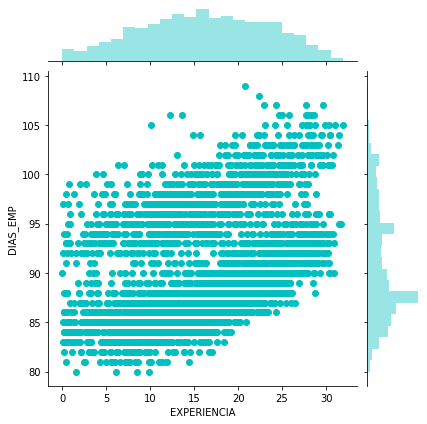

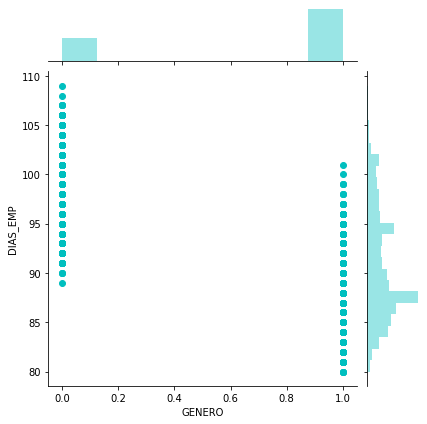

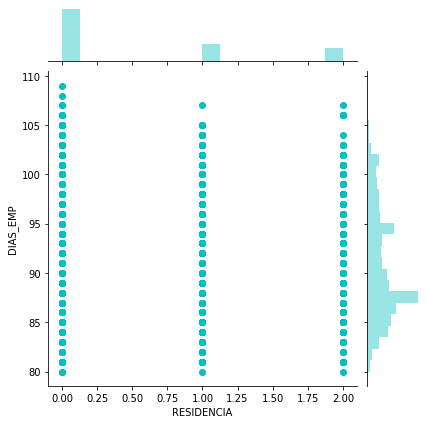

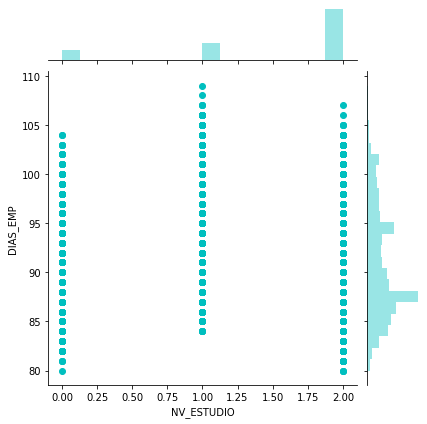

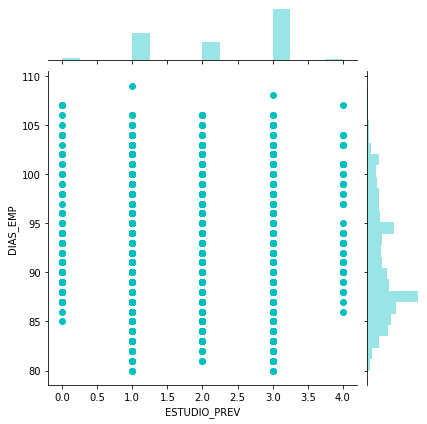

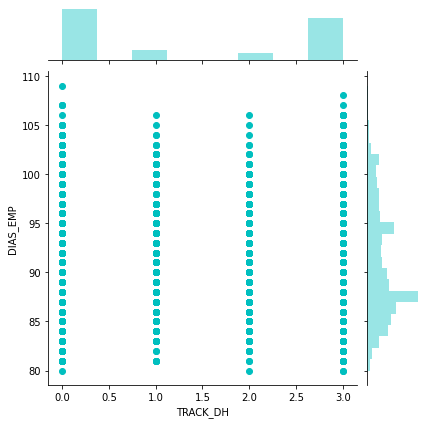

In [138]:
columnas_encoder =  [v for v in columnas_no_numericas if v not in [columna_target] ]
df3 = DataLabelEncoderTransform(columns=columnas_encoder).fit_transform(df_training_dataset_2)
graficar_carateristicas(df3,columna_target)

### Codificando variables categóricas

In [139]:
# Columnas One-hot-encoding del dataset usando el metodo de Pandas ``get_dummies`` (demontración)
columnas_dumies=['GENERO','RESIDENCIA','NV_ESTUDIO','ESTUDIO_PREV','TRACK_DH']
df_training_dataset_3 = pd.get_dummies(df_training_dataset_2, columns=columnas_dumies)
df_training_dataset_3.tail()

,EXPERIENCIA,DIAS_EMP,GENERO_FEMENINO,GENERO_MASCULINO,RESIDENCIA_ARGENTINA,RESIDENCIA_BRAZIL,RESIDENCIA_MEXICO,NV_ESTUDIO_POST_GRADUATE,NV_ESTUDIO_TERTIARY,NV_ESTUDIO_UNIVERSITARY,ESTUDIO_PREV_BUSINESS,ESTUDIO_PREV_COMMERCIAL,ESTUDIO_PREV_DEVELOPMENT,ESTUDIO_PREV_ENGINEERING,ESTUDIO_PREV_MARKETING,TRACK_DH_DATA,TRACK_DH_EJECUTIVO,TRACK_DH_MARKETING,TRACK_DH_PROGRAMACION
8984,25.0,106.0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
8988,20.9,86.0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0
8992,5.6,95.0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
8993,0.9,87.0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1
8994,19.6,88.0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0


### Seleccionando las columnas "features" y "target"

In [140]:
df_training_dataset_3.columns

Index(['EXPERIENCIA', 'DIAS_EMP', 'GENERO_FEMENINO', 'GENERO_MASCULINO',
       'RESIDENCIA_ARGENTINA', 'RESIDENCIA_BRAZIL', 'RESIDENCIA_MEXICO',
       'NV_ESTUDIO_POST_GRADUATE', 'NV_ESTUDIO_TERTIARY',
       'NV_ESTUDIO_UNIVERSITARY', 'ESTUDIO_PREV_BUSINESS',
       'ESTUDIO_PREV_COMMERCIAL', 'ESTUDIO_PREV_DEVELOPMENT',
       'ESTUDIO_PREV_ENGINEERING', 'ESTUDIO_PREV_MARKETING', 'TRACK_DH_DATA',
       'TRACK_DH_EJECUTIVO', 'TRACK_DH_MARKETING', 'TRACK_DH_PROGRAMACION'],
      dtype='object')

In [141]:
columnas_modelo = [v for v in df_training_dataset_3.columns if v not in ['DIAS_EMP']]
print(columnas_modelo)
features = df_training_dataset_3[columnas_modelo
]

target = df_training_dataset_3['DIAS_EMP']  ## NO CAMBIE EL NOMBRE DE LA VARIABLE "target".

['EXPERIENCIA', 'GENERO_FEMENINO', 'GENERO_MASCULINO', 'RESIDENCIA_ARGENTINA', 'RESIDENCIA_BRAZIL', 'RESIDENCIA_MEXICO', 'NV_ESTUDIO_POST_GRADUATE', 'NV_ESTUDIO_TERTIARY', 'NV_ESTUDIO_UNIVERSITARY', 'ESTUDIO_PREV_BUSINESS', 'ESTUDIO_PREV_COMMERCIAL', 'ESTUDIO_PREV_DEVELOPMENT', 'ESTUDIO_PREV_ENGINEERING', 'ESTUDIO_PREV_MARKETING', 'TRACK_DH_DATA', 'TRACK_DH_EJECUTIVO', 'TRACK_DH_MARKETING', 'TRACK_DH_PROGRAMACION']


### Dividiendo el conjunto de datos para una "prueba ciega"

In [142]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=133)

### Entrenando un modelo de regresión lineal simple

In [143]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostClassifier,RandomForestRegressor
class_SVC = SGDRegressor(max_iter=10000, tol=1e-100)
class_RNN = MLPRegressor(random_state=1, max_iter=15500)
class_RID = Ridge(alpha=0.00001,max_iter=8000)
class_RFO = RandomForestRegressor(n_estimators=1000, random_state=1)
regression_model = VotingRegressor(estimators=[('SVC', class_SVC), ('RID', class_RID),('RNN',class_RNN),('RFO',class_RFO)])
regression_model.fit(X_train,y_train)

VotingRegressor(estimators=[('SVC', SGDRegressor(max_iter=10000, tol=1e-100)),
                            ('RID', Ridge(alpha=1e-05, max_iter=8000)),
                            ('RNN',
                             MLPRegressor(max_iter=15500, random_state=1)),
                            ('RFO',
                             RandomForestRegressor(n_estimators=1000,
                                                   random_state=1))])

### Evaluando el modelo de regresión con el método  "score()" de sklearn

In [144]:
regression_model.score(X_test, y_test)

0.9201331168908626

<hr>

## Completar los datos necesarios para entregar la solución

### Como entrega de su solución, esperamos los resultados numéricos predichos por su modelo. Como entrada utilizará el archivo "to_be_scored.csv"

In [154]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/to_be_scored_digitalhouse.csv
df_to_be_scored = pd.read_csv(r'to_be_scored_digitalhouse.csv')
df_to_be_scored.tail()

--2020-09-18 19:41:43--  https://raw.githubusercontent.com/vanderlei-test/654986294958/master/to_be_scored_digitalhouse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.204.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.204.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67308 (66K) [text/plain]
Saving to: ‘to_be_scored_digitalhouse.csv.6’

to_be_scored_digita 100%[===================>]  65.73K   270KB/s    in 0.2s    

2020-09-18 19:41:44 (270 KB/s) - ‘to_be_scored_digitalhouse.csv.6’ saved [67308/67308]



,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,Unnamed: 10
995,995,33.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,PROGRAMACION,3.6,4576.5,15.1,NaN
996,996,40.0,MASCULINO,ARGENTINA,TERTIARY,COMMERCIAL,PROGRAMACION,3.4,4542.9,26.1,NaN
997,997,NaN,FEMENINO,ARGENTINA,UNIVERSITARY,ENGINEERING,DATA,3.4,NaN,27.4,NaN
998,998,NaN,MASCULINO,MEXICO,UNIVERSITARY,ENGINEERING,DATA,3.7,4730.4,1.1,NaN
999,999,36.0,NaN,ARGENTINA,UNIVERSITARY,NaN,PROGRAMACION,3.3,4506.5,20.4,NaN


# ¡Atención!

### El marco de datos ``to_be_scored`` es su "hoja de evaluación". Tenga en cuenta que la columna "target" no existe en esta muestra, por lo que no se puede utilizar para modelos de entrenamiento basados en el aprendizaje supervisado.

# ¡Atención!

### Debes realizar los mismos pasos de procesamiento previo que hiciste en el conjunto de datos de entrenamiento antes de calificar la "hoja de respuestas"

In [163]:
columnas_eliminar = ['Unnamed: 0','Unnamed: 10','EDAD','AVG_DH','MINUTES_DH']
df_to_be_scored_1 = df_to_be_scored.drop(columns=columnas_eliminar, inplace=False)
display(df_to_be_scored_1)

df_to_be_scored_2 = df_to_be_scored_1.dropna()

df_to_be_scored_3 = pd.get_dummies(df_to_be_scored_2, columns=columnas_dumies)
df_to_be_scored_3.tail()

,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,EXPERIENCIA
0,MASCULINO,ARGENTINA,POST_GRADUATE,ENGINEERING,PROGRAMACION,NaN
1,FEMENINO,BRAZIL,UNIVERSITARY,COMMERCIAL,DATA,25.6
2,FEMENINO,ARGENTINA,UNIVERSITARY,DEVELOPMENT,NaN,19.0
3,NaN,MEXICO,TERTIARY,DEVELOPMENT,MARKETING,18.4
4,MASCULINO,NaN,POST_GRADUATE,COMMERCIAL,PROGRAMACION,19.1
...,...,...,...,...,...,...
995,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,PROGRAMACION,15.1
996,MASCULINO,ARGENTINA,TERTIARY,COMMERCIAL,PROGRAMACION,26.1
997,FEMENINO,ARGENTINA,UNIVERSITARY,ENGINEERING,DATA,27.4
998,MASCULINO,MEXICO,UNIVERSITARY,ENGINEERING,DATA,1.1


,EXPERIENCIA,GENERO_FEMENINO,GENERO_MASCULINO,RESIDENCIA_ARGENTINA,RESIDENCIA_BRAZIL,RESIDENCIA_MEXICO,NV_ESTUDIO_POST_GRADUATE,NV_ESTUDIO_TERTIARY,NV_ESTUDIO_UNIVERSITARY,ESTUDIO_PREV_BUSINESS,ESTUDIO_PREV_COMMERCIAL,ESTUDIO_PREV_DEVELOPMENT,ESTUDIO_PREV_ENGINEERING,ESTUDIO_PREV_MARKETING,TRACK_DH_DATA,TRACK_DH_EJECUTIVO,TRACK_DH_MARKETING,TRACK_DH_PROGRAMACION
993,6.4,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
995,15.1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
996,26.1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1
997,27.4,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0
998,1.1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0


In [164]:
df_to_be_scored_3.columns

Index(['EXPERIENCIA', 'GENERO_FEMENINO', 'GENERO_MASCULINO',
       'RESIDENCIA_ARGENTINA', 'RESIDENCIA_BRAZIL', 'RESIDENCIA_MEXICO',
       'NV_ESTUDIO_POST_GRADUATE', 'NV_ESTUDIO_TERTIARY',
       'NV_ESTUDIO_UNIVERSITARY', 'ESTUDIO_PREV_BUSINESS',
       'ESTUDIO_PREV_COMMERCIAL', 'ESTUDIO_PREV_DEVELOPMENT',
       'ESTUDIO_PREV_ENGINEERING', 'ESTUDIO_PREV_MARKETING', 'TRACK_DH_DATA',
       'TRACK_DH_EJECUTIVO', 'TRACK_DH_MARKETING', 'TRACK_DH_PROGRAMACION'],
      dtype='object')

<hr>

### Hacer las predicciones con el método "predict()" de sklearn y agregar los resultados en el marco de datos de la "hoja de evaluación"

In [165]:
y_pred = regression_model.predict(df_to_be_scored_3)
df_to_be_scored_3['target'] = y_pred
df_to_be_scored_3.tail()

,EXPERIENCIA,GENERO_FEMENINO,GENERO_MASCULINO,RESIDENCIA_ARGENTINA,RESIDENCIA_BRAZIL,RESIDENCIA_MEXICO,NV_ESTUDIO_POST_GRADUATE,NV_ESTUDIO_TERTIARY,NV_ESTUDIO_UNIVERSITARY,ESTUDIO_PREV_BUSINESS,ESTUDIO_PREV_COMMERCIAL,ESTUDIO_PREV_DEVELOPMENT,ESTUDIO_PREV_ENGINEERING,ESTUDIO_PREV_MARKETING,TRACK_DH_DATA,TRACK_DH_EJECUTIVO,TRACK_DH_MARKETING,TRACK_DH_PROGRAMACION,target
993,6.4,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,85.113430
995,15.1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,86.327315
996,26.1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,93.200204
997,27.4,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,100.307770
998,1.1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,82.485335


# ¡Atención!

### La columna agregada con los resultados debe llamarse "target", de lo contrario, su envío fallará.

<hr>

### Exportar el marco de datos de resultados como un archivo .csv a su proyecto de Watson Studio.

In [166]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

NameError: name 'project' is not defined